Our preliminary results show that the MMS + null model pairing works extraordinarily well. In fact, it works so well that we are having trouble believing it. We hypothesize that it does well because some bulks/surfaces in our dataset have very few sites. For example:
- Say that one surface has one site, while a different surface has 20. During the Active Learning portion of MMS, we pick the surface with more uncertainty. If all sites are yet unsampled, then we will probably pick the surface with one site because it will have a wider uncertainty.
- Now that the surface with one site is fully sampled, it contributes much less uncertainty to the value of the bulk. This bulk will now be much more certain than other, similar bulks.
- Similarly, bulk with fewer surfaces are likely to have wider uncertainties and are therefore less likely to be chosen during the Level Set Estimation portion of MMS.

This means than MMS may disproportionaly choose to sample materials with less sites. Which is not necessarily bad in practice, but in our hallucinations it becomes disproportionaly good at filling out a wide search space very quickly.

To temper this exceedingly good performance, we hypothesize that removing bulks from the data set that have very few adsorption sites may mitigate this issue. To test this, we must first take out the bulks with few sites. Kirby did some offline testing and found that 40 is a good number to start with. So that's where we start.

In [1]:
adsorbates = {'CO', 'H', 'OH'}

# Truncate bulks by n sites per bulk

In [12]:
from collections import defaultdict
from tqdm.notebook import tqdm
import ase.db


min_sites = 40
dbs = {ads: ase.db.connect(ads + '/%s.db' % ads) for ads in adsorbates}

# Initialize
for ads, db in dbs.items():
    sites_per_mpid = defaultdict(int)
    atomss = []
    docs = []

    # Count the number of sites per MPID
    for row in tqdm(db.select(), desc='Reading %s' % ads, total=db.count()):
        sites_per_mpid[row.data['mpid']] += 1

        # Rip the data out
        atomss.append(row.toatoms())
        docs.append(row.data)

    # Re-save the databases with sufficient numbers of sites
    good_mpids = {mpid for mpid, n_sites in sites_per_mpid.items() if n_sites >= min_sites}
    new_db = ase.db.connect(ads + '_truncated/%s.db' % ads)
    for atoms, doc in tqdm(zip(atomss, docs), desc='Writing %s' % ads, total=len(docs)):
        if doc['mpid'] in good_mpids:
            new_db.write(atoms, data=doc)

# Truncate bulks by n sites per surfaces per bulk
If there are too many surfaces per bulk, then this same issue might still be affecting us, but at the surface/bulk level instead of the site/surface level. Let us first see how bad this issue is by plotting the number of sites per surface per bulk.

In [17]:
from tqdm.notebook import tqdm
import ase.db


# Grab data
adsorbate = 'CO'
db = ase.db.connect(adsorbate + '/%s.db' % adsorbate)

# Parse the data
sites_per_bulk_per_surface = {}
for row in tqdm(db.select(), desc='parsing', total=db.count()):
    data = row.data
    mpid = data['mpid']
    surface = tuple(data['miller'].tolist())

    # Find or initialize the sites per surface dict
    try:
        sites_per_surface = sites_per_bulk_per_surface[mpid]
    except KeyError:
        sites_per_bulk_per_surface[mpid] = {}
        sites_per_surface = sites_per_bulk_per_surface[mpid]

    # Increment or initialize the count of sites per surface
    try:
        sites_per_surface[surface] += 1
    except KeyError:
        sites_per_surface[surface] = 1

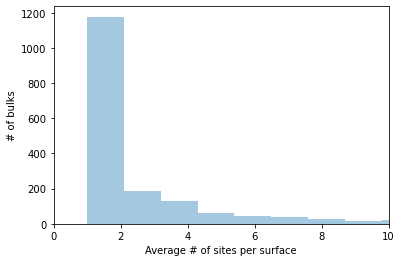

In [33]:
import numpy as np
import seaborn as sns


mean_sites_per_surface_per_bulk = {mpid: np.array(list(sites_per_surface.values())).mean()
                                   for mpid, sites_per_surface in sites_per_bulk_per_surface.items()}

ax = sns.distplot(list(mean_sites_per_surface_per_bulk.values()), kde=False)
_ = ax.set_xlabel('Average # of sites per surface')
_ = ax.set_ylabel('# of bulks')
_ = ax.set_xlim([0, 10])

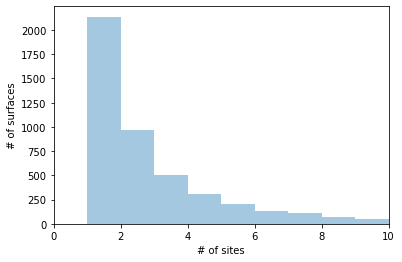

In [42]:
import numpy as np
import seaborn as sns


n_sites_per_surface = [n_sites
                       for sites_per_surface in sites_per_bulk_per_surface.values()
                       for n_sites in sites_per_surface.values()]

ax = sns.distplot(n_sites_per_surface, kde=False, bins=range(0, 12))
_ = ax.set_xlabel('# of sites')
_ = ax.set_ylabel('# of surfaces')
_ = ax.set_xlim([0, 10])

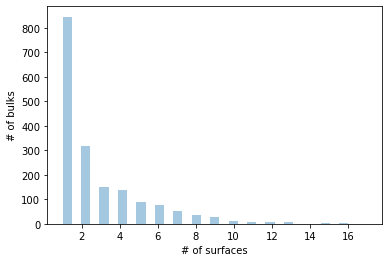

In [35]:
import numpy as np
import seaborn as sns


surfaces_per_bulk = {mpid: len(sites_per_surface.keys())
                     for mpid, sites_per_surface in sites_per_bulk_per_surface.items()}

ax = sns.distplot(list(surfaces_per_bulk.values()), kde=False)
_ = ax.set_xlabel('# of surfaces')
_ = ax.set_ylabel('# of bulks')

# Truncate bulks by n sites per surfaces per bulk... AND by # sites per bulk
The plots in the section just above don't look the best. Seems like most bulks have une surface and most surfaces have one site. Looks like we need to truncate by # sites per bulk. But can we combine both truncation and pooling?

To do this, we first figure out which MPID's have sufficient data

In [46]:
from tqdm.notebook import tqdm
import ase.db


# Grab data
min_sites = 40
adsorbate = 'CO'
db = ase.db.connect(adsorbate + '/%s.db' % adsorbate)

# Count the number of sites per MPID
sites_per_mpid = defaultdict(int)
for row in tqdm(db.select(), total=db.count()):
    sites_per_mpid[row.data['mpid']] += 1

# Identify good MPIDs
good_mpids = {mpid for mpid, n_sites in sites_per_mpid.items() if n_sites >= min_sites}

In [47]:
from tqdm.notebook import tqdm
import ase.db


# Grab data
adsorbate = 'CO'
db = ase.db.connect(adsorbate + '/%s.db' % adsorbate)

# Parse the data
sites_per_bulk_per_surface = {}
for row in tqdm(db.select(), desc='parsing', total=db.count()):
    data = row.data
    mpid = data['mpid']
    
    # Only take data from "the good ones"
    if mpid in good_mpids:
        surface = tuple(data['miller'].tolist())

        # Find or initialize the sites per surface dict
        try:
            sites_per_surface = sites_per_bulk_per_surface[mpid]
        except KeyError:
            sites_per_bulk_per_surface[mpid] = {}
            sites_per_surface = sites_per_bulk_per_surface[mpid]

        # Increment or initialize the count of sites per surface
        try:
            sites_per_surface[surface] += 1
        except KeyError:
            sites_per_surface[surface] = 1

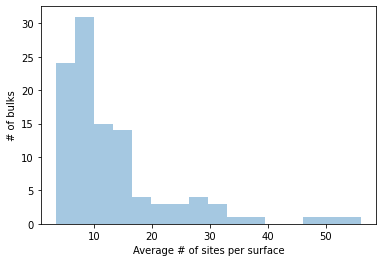

In [51]:
import numpy as np
import seaborn as sns


mean_sites_per_surface_per_bulk = {mpid: np.array(list(sites_per_surface.values())).mean()
                                   for mpid, sites_per_surface in sites_per_bulk_per_surface.items()}

ax = sns.distplot(list(mean_sites_per_surface_per_bulk.values()), kde=False)
_ = ax.set_xlabel('Average # of sites per surface')
_ = ax.set_ylabel('# of bulks')
#_ = ax.set_xlim([0, 10])

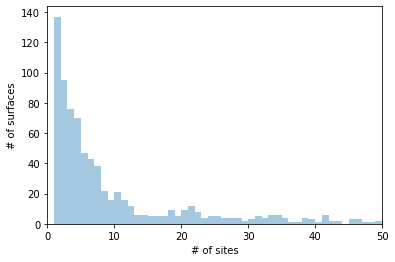

In [53]:
import numpy as np
import seaborn as sns


n_sites_per_surface = [n_sites
                       for sites_per_surface in sites_per_bulk_per_surface.values()
                       for n_sites in sites_per_surface.values()]

ax = sns.distplot(n_sites_per_surface, kde=False, bins=range(0, 51))
_ = ax.set_xlabel('# of sites')
_ = ax.set_ylabel('# of surfaces')
_ = ax.set_xlim([0, 50])

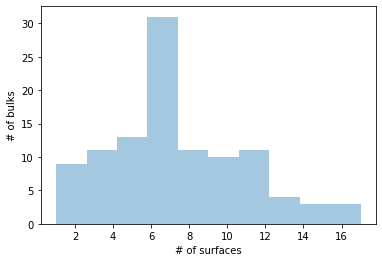

In [54]:
import numpy as np
import seaborn as sns


surfaces_per_bulk = {mpid: len(sites_per_surface.keys())
                     for mpid, sites_per_surface in sites_per_bulk_per_surface.items()}

ax = sns.distplot(list(surfaces_per_bulk.values()), kde=False)
_ = ax.set_xlabel('# of surfaces')
_ = ax.set_ylabel('# of bulks')

In [57]:
len(good_mpids)

106

In [58]:
surfaces = {(mpid, miller)
            for mpid, sites_per_surface in sites_per_bulk_per_surface.items()
            for miller in sites_per_surface.keys()}
len(surfaces)

773